# 06차시: 데이터 전처리 - 결측치 및 이상치 처리

## 학습 목표
- 실제 데이터에 존재하는 결측값(NaN) 처리 방법 학습
- 비정상적인 값(이상치)을 찾아내고 처리하는 기본 기법 학습

## 학습 내용
1. 결측치란?
2. 결측치 탐지 및 확인
3. 결측치 처리 방법
4. 이상치란?
5. 이상치 탐지 방법
6. 이상치 처리 방법
7. 종합 실습

## 구분
이론/실습

---
금융 데이터 분석에서 데이터 품질은 분석 결과의 신뢰성을 좌우합니다.
결측치와 이상치 처리는 모든 데이터 분석의 필수 전처리 과정입니다.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
✅ Korean font ready: NanumGothic
   - path: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


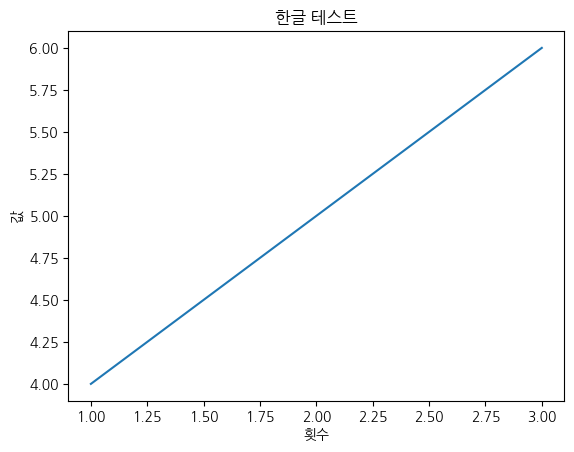

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import gridspec
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def setup_korean_font_colab(force=False, verbose=True):
    """
    Colab + Matplotlib에서 한글이 절대 깨지지 않도록 하는 통합 함수

    - 폰트 설치 (최초 1회)
    - fontManager에 즉시 등록 (런타임 재시작 불필요)
    - rcParams 재확정 (새 Figure, 로그 스케일, legend 대응)
    - PDF 저장 시 폰트 임베딩까지 처리

    force=True  -> rcParams를 무조건 다시 설정
    """

    import os
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

    # 1) 폰트 설치 (없을 때만)
    if not os.path.exists(font_path):
        !apt-get update -qq
        !apt-get install -y fonts-nanum -qq

    # 2) Matplotlib에 폰트 등록 (중요: 재시작 불필요)
    try:
        fm.fontManager.addfont(font_path)
    except Exception:
        pass  # 이미 등록돼 있으면 무시

    # 3) 폰트 이름 확정
    font_name = fm.FontProperties(fname=font_path).get_name()

    # 4) rcParams 재확정
    mpl.rcParams["font.family"] = font_name
    mpl.rcParams["axes.unicode_minus"] = False
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42

    if verbose:
        print(f"✅ Korean font ready: {font_name}")
        print(f"   - path: {font_path}")

    return font_name

setup_korean_font_colab()

#테스트
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 테스트')
plt.xlabel('횟수')
plt.ylabel('값')
plt.show()

In [2]:
import pandas as pd
import numpy as np

# 실습용 가상 주가 데이터 생성
print("[실습 데이터 준비: 가상 주가 데이터]")
print("=" * 60)

# 재현성을 위한 시드 설정
np.random.seed(42)

# 50일 영업일 기준 날짜 생성
dates = pd.date_range('2024-01-01', periods=50, freq='B')

# 기준 가격 (삼성전자 수준의 가격대)
base_price = 70000

# 가격 변동 시뮬레이션 (랜덤워크)
price_changes = np.random.randn(50) * 800  # 일일 변동폭 약 ±800원
prices = base_price + np.cumsum(price_changes)

# OHLCV 데이터 생성
df = pd.DataFrame({
    '시가': (prices + np.random.randn(50) * 200).astype(int),
    '고가': (prices + abs(np.random.randn(50) * 500)).astype(int),
    '저가': (prices - abs(np.random.randn(50) * 500)).astype(int),
    '종가': prices.astype(int),
    '거래량': np.random.randint(10_000_000, 25_000_000, 50)
}, index=dates)
df.index.name = '날짜'

# 고가가 종가보다 크고, 저가가 종가보다 작도록 보정
df['고가'] = df[['고가', '종가', '시가']].max(axis=1)
df['저가'] = df[['저가', '종가', '시가']].min(axis=1)

print(f"종목: 가상 주식 (삼성전자 수준)")
print(f"데이터 크기: {df.shape[0]}행 x {df.shape[1]}열")
print(f"컬럼: {df.columns.tolist()}")
print(f"기간: {df.index[0].strftime('%Y-%m-%d')} ~ {df.index[-1].strftime('%Y-%m-%d')}")

df.head()

[실습 데이터 준비: 가상 주가 데이터]
종목: 가상 주식 (삼성전자 수준)
데이터 크기: 50행 x 5열
컬럼: ['시가', '고가', '저가', '종가', '거래량']
기간: 2024-01-01 ~ 2024-03-08


,시가,고가,저가,종가,거래량
날짜,,,,,
2024-01-01,70462,71105,70272,70397,20192257
2024-01-02,70209,70497,70113,70286,19613273
2024-01-03,70669,70976,70464,70804,20683152
2024-01-04,72145,72424,71907,72023,14353127
2024-01-05,72042,72042,71689,71836,17315360


## 1. 결측치(Missing Value)란?

### 정의
- 데이터에서 값이 비어있거나 누락된 경우
- Pandas에서는 `NaN` (Not a Number) 또는 `None`으로 표현

### 결측치 발생 원인
| 원인 | 예시 |
|------|------|
| 데이터 수집 오류 | API 호출 실패, 네트워크 끊김 |
| 데이터 입력 누락 | 사람이 직접 입력하다 빠뜨림 |
| 시스템 장애 | 거래소 휴장, 시스템 점검 |
| 데이터 병합 | 서로 다른 기간의 데이터 합치기 |

### 금융 데이터에서의 결측치
- 휴장일 데이터 없음
- 신규 상장 이전 기간 데이터 없음
- 데이터 제공 서비스 오류


In [3]:
# 실습을 위해 인위적으로 결측치 생성
print("[결측치 포함 데이터 생성]")
print("=" * 60)

# 원본 데이터 복사
df_missing = df.copy()

# 결측치를 삽입할 위치 선택 (인덱스 5, 10, 15, 20, 25번째)
missing_positions = [5, 10, 15, 20, 25, 30, 35, 40]
missing_idx = df_missing.index[missing_positions]

# 종가에 결측치 삽입 (4개)
df_missing.loc[missing_idx[:4], '종가'] = np.nan
# 거래량에 결측치 삽입 (4개)
df_missing.loc[missing_idx[4:], '거래량'] = np.nan

print("결측치가 포함된 데이터 생성 완료!")
print(f"데이터 크기: {len(df_missing)}행")
print(f"\n결측치 삽입 위치:")
print(f"  - 종가 결측: {[d.strftime('%m/%d') for d in missing_idx[:4]]}")
print(f"  - 거래량 결측: {[d.strftime('%m/%d') for d in missing_idx[4:]]}")

[결측치 포함 데이터 생성]
결측치가 포함된 데이터 생성 완료!
데이터 크기: 50행

결측치 삽입 위치:
  - 종가 결측: ['01/08', '01/15', '01/22', '01/29']
  - 거래량 결측: ['02/05', '02/12', '02/19', '02/26']


## 2. 결측치 탐지 및 확인

### 주요 함수
| 함수 | 설명 |
|------|------|
| `df.isnull()` | 결측치 여부 (True/False) |
| `df.isna()` | isnull()과 동일 |
| `df.notnull()` | 결측치가 아닌지 여부 |
| `df.isnull().sum()` | 컬럼별 결측치 개수 |
| `df.info()` | 데이터 정보 (Non-Null Count 포함) |


In [4]:
# 결측치 탐지 방법 1: isnull()
print("[결측치 탐지: isnull()]")
print("=" * 60)

# 결측치 여부 확인 (처음 10행)
print("결측치 여부 (True = 결측치):")
print(df_missing.isnull().head(10))

print("\n" + "=" * 60)
# 컬럼별 결측치 개수
print("[컬럼별 결측치 개수]")
print(df_missing.isnull().sum())

[결측치 탐지: isnull()]
결측치 여부 (True = 결측치):
               시가     고가     저가     종가    거래량
날짜                                           
2024-01-01  False  False  False  False  False
2024-01-02  False  False  False  False  False
2024-01-03  False  False  False  False  False
2024-01-04  False  False  False  False  False
2024-01-05  False  False  False  False  False
2024-01-08  False  False  False   True  False
2024-01-09  False  False  False  False  False
2024-01-10  False  False  False  False  False
2024-01-11  False  False  False  False  False
2024-01-12  False  False  False  False  False

[컬럼별 결측치 개수]
시가     0
고가     0
저가     0
종가     4
거래량    4
dtype: int64


In [5]:
# 결측치 탐지 방법 2: info()
print("[데이터 정보: info()]")
print("=" * 60)
df_missing.info()

[데이터 정보: info()]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2024-01-01 to 2024-03-08
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가      50 non-null     int64  
 1   고가      50 non-null     int64  
 2   저가      50 non-null     int64  
 3   종가      46 non-null     float64
 4   거래량     46 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 4.4 KB


In [6]:
# 결측치가 있는 행 찾기
print("[결측치가 있는 행 확인]")
print("=" * 60)

# 어떤 컬럼이든 결측치가 있는 행
rows_with_missing = df_missing[df_missing.isnull().any(axis=1)]
print(f"결측치가 있는 행 개수: {len(rows_with_missing)}개")
print("\n결측치가 있는 행:")
print(rows_with_missing)

# 결측치 비율 계산
print("\n" + "=" * 60)
print("[결측치 비율]")
missing_ratio = (df_missing.isnull().sum() / len(df_missing) * 100).round(2)
print(missing_ratio)

[결측치가 있는 행 확인]
결측치가 있는 행 개수: 8개

결측치가 있는 행:
               시가     고가     저가       종가         거래량
날짜                                                  
2024-01-08  71834  71850  71291      NaN  24024490.0
2024-01-15  73117  74173  72726      NaN  13295990.0
2024-01-22  69945  69945  69467      NaN  23246988.0
2024-01-29  68504  68827  67986      NaN  16099628.0
2024-02-05  66982  67913  66404  66818.0         NaN
2024-02-12  64959  65778  64690  65003.0         NaN
2024-02-19  65208  66084  64952  65309.0         NaN
2024-02-26  63613  63708  63371  63594.0         NaN

[결측치 비율]
시가     0.0
고가     0.0
저가     0.0
종가     8.0
거래량    8.0
dtype: float64


## 3. 결측치 처리 방법

### 처리 방법 비교
| 방법 | 설명 | 장점 | 단점 |
|------|------|------|------|
| **삭제** | 결측치가 있는 행/열 제거 | 간단함 | 데이터 손실 |
| **대체 (평균)** | 평균값으로 채움 | 분포 유지 | 분산 감소 |
| **대체 (중앙값)** | 중앙값으로 채움 | 이상치에 강함 | 분산 감소 |
| **전방 채움** | 앞의 값으로 채움 | 시계열에 적합 | 트렌드 왜곡 가능 |
| **후방 채움** | 뒤의 값으로 채움 | 시계열에 적합 | 트렌드 왜곡 가능 |
| **보간법** | 선형/다항 보간 | 연속성 유지 | 복잡함 |

### 주요 함수
```python
df.dropna()              # 결측치가 있는 행 삭제
df.dropna(axis=1)        # 결측치가 있는 열 삭제
df.fillna(값)            # 특정 값으로 대체
df.fillna(method='ffill') # 전방 채움 (Forward Fill)
df.fillna(method='bfill') # 후방 채움 (Backward Fill)
df.interpolate()         # 선형 보간
```


In [7]:
# Step 1: 결측치 위치와 주변 값 확인
print("=" * 60)
print("[Step 1] 결측치 위치와 주변 값 확인")
print("=" * 60)

# 종가에서 결측치가 있는 날짜 찾기
missing_dates = df_missing[df_missing['종가'].isnull()].index
print(f"\n종가 결측치 개수: {len(missing_dates)}개")
print(f"결측치 날짜: {[d.strftime('%m/%d') for d in missing_dates]}")

# 결측치 주변 데이터 확인 (첫 번째 결측치 기준)
first_missing = missing_dates[0]
first_missing_pos = df_missing.index.get_loc(first_missing)

print(f"\n[첫 번째 결측치 주변 데이터]")
print(f"위치: {first_missing.strftime('%Y-%m-%d')} (인덱스 {first_missing_pos})")
print("-" * 40)

# 결측치 앞뒤 2일씩 출력
start_pos = max(0, first_missing_pos - 2)
end_pos = min(len(df_missing), first_missing_pos + 3)
subset = df_missing.iloc[start_pos:end_pos][['종가']].copy()
subset['상태'] = subset['종가'].apply(lambda x: '← 결측치' if pd.isna(x) else '')
subset

[Step 1] 결측치 위치와 주변 값 확인

종가 결측치 개수: 4개
결측치 날짜: ['01/08', '01/15', '01/22', '01/29']

[첫 번째 결측치 주변 데이터]
위치: 2024-01-08 (인덱스 5)
----------------------------------------


,종가,상태
날짜,,
2024-01-04,72023.0,
2024-01-05,71836.0,
2024-01-08,NaN,← 결측치
2024-01-09,72912.0,
2024-01-10,73526.0,


In [8]:
# Step 2: 방법 1 - 평균값으로 대체
print("=" * 60)
print("[Step 2] 방법 1: 평균값으로 대체 (fillna)")
print("=" * 60)

# 평균값 계산
mean_val = df_missing['종가'].mean()
print(f"\n종가 평균 (결측치 제외): {mean_val:,.0f}원")

# 평균값으로 대체
df_mean = df_missing.copy()
df_mean['종가'] = df_mean['종가'].fillna(mean_val)

# 처리 전후 비교
print("\n[처리 전후 비교]")
print("-" * 50)
comparison = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '평균대체': df_mean.loc[missing_dates, '종가'].astype(int)
})
print(comparison)

print(f"\n→ 모든 결측치가 동일한 값({mean_val:,.0f}원)으로 채워짐")
print("→ 단점: 시간 흐름에 따른 추세를 반영하지 못함")

[Step 2] 방법 1: 평균값으로 대체 (fillna)

종가 평균 (결측치 제외): 67,078원

[처리 전후 비교]
--------------------------------------------------
            처리 전   평균대체
날짜                     
2024-01-08   NaN  67078
2024-01-15   NaN  67078
2024-01-22   NaN  67078
2024-01-29   NaN  67078

→ 모든 결측치가 동일한 값(67,078원)으로 채워짐
→ 단점: 시간 흐름에 따른 추세를 반영하지 못함


In [9]:
# Step 3: 방법 2, 3 - 전방/후방 채움
print("=" * 60)
print("[Step 3] 방법 2: 전방 채움 (ffill) - 앞의 값으로 채움")
print("=" * 60)

# 전방 채움
df_ffill = df_missing.copy()
df_ffill['종가'] = df_ffill['종가'].ffill()

print("\n원리: 결측치를 바로 앞(전일)의 유효한 값으로 채움")
print("      → 주가 데이터에서 가장 많이 사용 (전일 종가 사용)")

# 처리 전후 비교
print("\n[처리 전후 비교]")
print("-" * 50)
comparison_ffill = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '전방채움': df_ffill.loc[missing_dates, '종가'].astype(int)
})
print(comparison_ffill)

# 후방 채움
print("\n" + "=" * 60)
print("[Step 3] 방법 3: 후방 채움 (bfill) - 뒤의 값으로 채움")
print("=" * 60)

df_bfill = df_missing.copy()
df_bfill['종가'] = df_bfill['종가'].bfill()

print("\n원리: 결측치를 바로 뒤(다음 거래일)의 유효한 값으로 채움")
print("      → 미래 데이터를 사용하므로 주의 필요")

print("\n[처리 전후 비교]")
print("-" * 50)
comparison_bfill = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '후방채움': df_bfill.loc[missing_dates, '종가'].astype(int)
})
print(comparison_bfill)

[Step 3] 방법 2: 전방 채움 (ffill) - 앞의 값으로 채움

원리: 결측치를 바로 앞(전일)의 유효한 값으로 채움
      → 주가 데이터에서 가장 많이 사용 (전일 종가 사용)

[처리 전후 비교]
--------------------------------------------------
            처리 전   전방채움
날짜                     
2024-01-08   NaN  71836
2024-01-15   NaN  73584
2024-01-22   NaN  70124
2024-01-29   NaN  67259

[Step 3] 방법 3: 후방 채움 (bfill) - 뒤의 값으로 채움

원리: 결측치를 바로 뒤(다음 거래일)의 유효한 값으로 채움
      → 미래 데이터를 사용하므로 주의 필요

[처리 전후 비교]
--------------------------------------------------
            처리 전   후방채움
날짜                     
2024-01-08   NaN  72912
2024-01-15   NaN  72841
2024-01-22   NaN  68864
2024-01-29   NaN  68251


In [10]:
# Step 4: 방법 4 - 선형 보간 + 전체 비교표
print("=" * 60)
print("[Step 4] 방법 4: 선형 보간 (interpolate)")
print("=" * 60)

# 선형 보간
df_interp = df_missing.copy()
df_interp['종가'] = df_interp['종가'].interpolate(method='linear')

print("\n원리: 앞뒤 값 사이를 균등하게 나눠서 채움")
print("      예) 앞=70000, 뒤=72000 → 결측치=71000 (중간값)")

print("\n[처리 전후 비교]")
print("-" * 50)
comparison_interp = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '선형보간': df_interp.loc[missing_dates, '종가'].astype(int)
})
print(comparison_interp)

# 전체 비교표
print("\n" + "=" * 60)
print("[Step 5] 모든 방법 비교표")
print("=" * 60)

# 모든 방법 결과를 하나의 표로
all_comparison = pd.DataFrame({
    '원본(결측)': df_missing.loc[missing_dates, '종가'],
    '평균대체': df_mean.loc[missing_dates, '종가'].astype(int),
    '전방채움': df_ffill.loc[missing_dates, '종가'].astype(int),
    '후방채움': df_bfill.loc[missing_dates, '종가'].astype(int),
    '선형보간': df_interp.loc[missing_dates, '종가'].astype(int)
})
print(all_comparison)

print("\n" + "=" * 60)
print("[결론] 각 방법의 특징")
print("=" * 60)
print("  - 평균대체: 간단하지만 모든 결측치가 같은 값 → 추세 무시")
print("  - 전방채움: 전일 종가 사용 → 주가 데이터에 가장 적합")
print("  - 후방채움: 미래 데이터 사용 → 예측에는 부적합")
print("  - 선형보간: 앞뒤 값의 중간 → 자연스러운 추세 반영")

[Step 4] 방법 4: 선형 보간 (interpolate)

원리: 앞뒤 값 사이를 균등하게 나눠서 채움
      예) 앞=70000, 뒤=72000 → 결측치=71000 (중간값)

[처리 전후 비교]
--------------------------------------------------
            처리 전   선형보간
날짜                     
2024-01-08   NaN  72374
2024-01-15   NaN  73212
2024-01-22   NaN  69494
2024-01-29   NaN  67755

[Step 5] 모든 방법 비교표
            원본(결측)   평균대체   전방채움   후방채움   선형보간
날짜                                            
2024-01-08     NaN  67078  71836  72912  72374
2024-01-15     NaN  67078  73584  72841  73212
2024-01-22     NaN  67078  70124  68864  69494
2024-01-29     NaN  67078  67259  68251  67755

[결론] 각 방법의 특징
  - 평균대체: 간단하지만 모든 결측치가 같은 값 → 추세 무시
  - 전방채움: 전일 종가 사용 → 주가 데이터에 가장 적합
  - 후방채움: 미래 데이터 사용 → 예측에는 부적합
  - 선형보간: 앞뒤 값의 중간 → 자연스러운 추세 반영


## 4. 이상치(Outlier)란?

### 정의
- 데이터의 일반적인 분포에서 크게 벗어난 값
- 다른 데이터와 비교했을 때 비정상적으로 크거나 작은 값

### 이상치 발생 원인
| 원인 | 예시 |
|------|------|
| 데이터 입력 오류 | 오타, 단위 착오 |
| 측정 장비 오류 | 센서 오작동 |
| 실제 이상 현상 | 급등/급락, 시장 충격 |
| 데이터 처리 오류 | 병합 오류, 계산 실수 |

### 금융 데이터에서의 이상치
- 주가 급등/급락 (실제 이상 현상)
- 거래량 이상 급증
- 데이터 수집 오류로 인한 잘못된 가격

### 이상치 처리 시 주의점
- 금융 데이터에서 이상치가 **실제 시장 이벤트**인지 확인 필요
- 무조건 제거하면 중요한 정보 손실 가능


## 5. 이상치 탐지 방법

### IQR (Interquartile Range) 방법
```
Q1 (25% 백분위수): 데이터의 25% 지점
Q3 (75% 백분위수): 데이터의 75% 지점
IQR = Q3 - Q1

하한: Q1 - 1.5 * IQR
상한: Q3 + 1.5 * IQR

하한 미만 또는 상한 초과 → 이상치
```



In [11]:
# 이상치 탐지 실습을 위한 데이터 준비
print("[이상치 포함 데이터 생성]")
print("=" * 60)

# 원본 데이터 복사
df_outlier = df.copy()

# 정상 데이터 범위 확인
print(f"정상 종가 범위: {df_outlier['종가'].min():,}원 ~ {df_outlier['종가'].max():,}원")

# 인위적으로 이상치 삽입 (실습용) - 고정된 위치 사용
outlier_positions = [3, 25, 40]
outlier_idx = df_outlier.index[outlier_positions]

# 종가에 이상치 삽입 (비정상적으로 높거나 낮은 값)
df_outlier.loc[outlier_idx[0], '종가'] = 150000  # 비정상적으로 높음 (2배 이상)
df_outlier.loc[outlier_idx[1], '종가'] = 20000   # 비정상적으로 낮음 (1/3 이하)

print("\n이상치가 포함된 데이터 생성 완료!")
print(f"\n삽입된 이상치:")
print(f"  - {outlier_idx[0].strftime('%m/%d')}: 종가 150,000원 (비정상적으로 높음)")
print(f"  - {outlier_idx[1].strftime('%m/%d')}: 종가 20,000원 (비정상적으로 낮음)")

[이상치 포함 데이터 생성]
정상 종가 범위: 60,981원 ~ 73,584원

이상치가 포함된 데이터 생성 완료!

삽입된 이상치:
  - 01/04: 종가 150,000원 (비정상적으로 높음)
  - 02/05: 종가 20,000원 (비정상적으로 낮음)


In [12]:
# 이상치 탐지 방법: IQR 방법
print("[이상치 탐지: IQR 방법]")
print("=" * 60)

# 종가 컬럼에 대해 IQR 계산
Q1 = df_outlier['종가'].quantile(0.25)
Q3 = df_outlier['종가'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25%): {Q1:,.0f}원")
print(f"Q3 (75%): {Q3:,.0f}원")
print(f"IQR: {IQR:,.0f}원")
print(f"\n이상치 판단 기준:")
print(f"  하한: {lower_bound:,.0f}원")
print(f"  상한: {upper_bound:,.0f}원")

# 이상치 탐지
outliers_iqr = df_outlier[(df_outlier['종가'] < lower_bound) | (df_outlier['종가'] > upper_bound)]
print(f"\n탐지된 이상치 개수: {len(outliers_iqr)}개")
print("\n이상치 데이터:")
print(outliers_iqr[['시가', '고가', '저가', '종가', '거래량']])

[이상치 탐지: IQR 방법]
Q1 (25%): 63,775원
Q3 (75%): 70,369원
IQR: 6,594원

이상치 판단 기준:
  하한: 53,884원
  상한: 80,260원

탐지된 이상치 개수: 2개

이상치 데이터:
               시가     고가     저가      종가       거래량
날짜                                               
2024-01-04  72145  72424  71907  150000  14353127
2024-02-05  66982  67913  66404   20000  19674733



[이상치 시각화: Box Plot]


/tmp/ipython-input-3042162616.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot([df_outlier['종가'], normal_data],


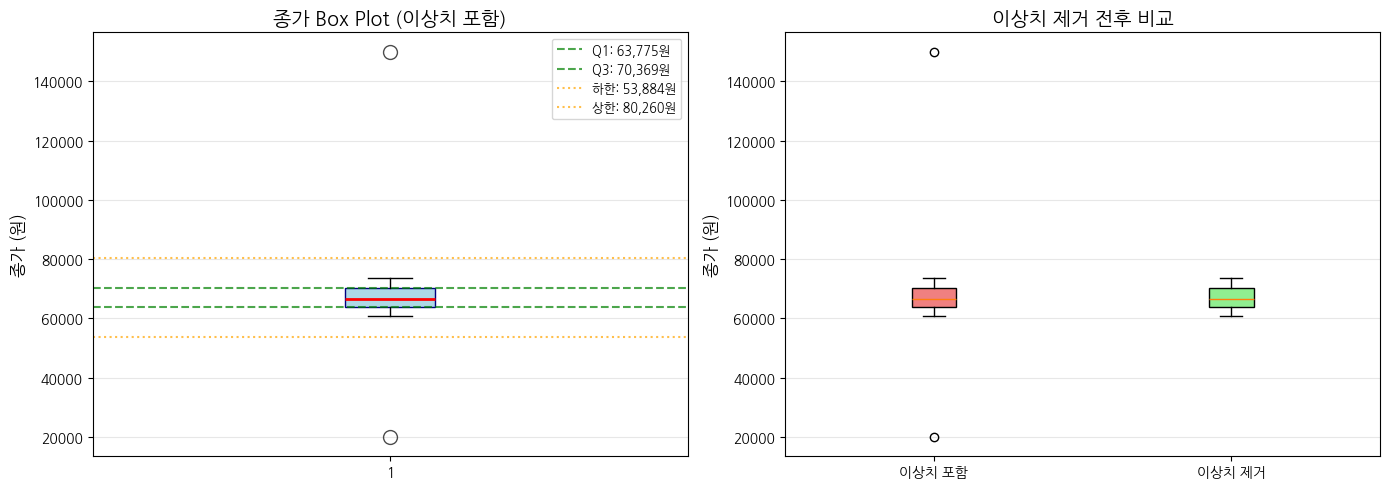


[Box Plot 구성요소 설명]
------------------------------------------------------------
  - 박스 상단: Q3 (75% 백분위수)
  - 박스 하단: Q1 (25% 백분위수)
  - 박스 내 빨간선: 중앙값 (Median)
  - 수염 (Whisker): Q1 - 1.5*IQR ~ Q3 + 1.5*IQR
  - 빨간 점: 이상치 (수염 범위를 벗어난 값)

[IQR 기반 이상치 판단]
  - Q1: 63,775원
  - Q3: 70,369원
  - IQR: 6,594원
  - 하한 (Q1 - 1.5*IQR): 53,884원
  - 상한 (Q3 + 1.5*IQR): 80,260원


In [13]:
# 이상치 시각화: Box Plot으로 IQR 방법 이해하기
print("\n[이상치 시각화: Box Plot]")
print("=" * 60)

import matplotlib.pyplot as plt

# 한글 폰트 설정 (Colab)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

import os
if not os.path.exists('/usr/share/fonts/truetype/nanum'):
    !apt-get install -y fonts-nanum > /dev/null 2>&1
    import matplotlib.font_manager as fm
    fm._rebuild()
    plt.rcParams['font.family'] = 'NanumGothic'

# 1. 기본 Box Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) 종가 Box Plot
bp1 = axes[0].boxplot(df_outlier['종가'], vert=True, patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][0].set_edgecolor('navy')
bp1['medians'][0].set_color('red')
bp1['medians'][0].set_linewidth(2)

# 이상치 강조 (빨간 점)
for flier in bp1['fliers']:
    flier.set(marker='o', color='red', markersize=10, alpha=0.7)

axes[0].set_title('종가 Box Plot (이상치 포함)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('종가 (원)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# IQR 범위 텍스트 추가
axes[0].axhline(y=Q1, color='green', linestyle='--', alpha=0.7, label=f'Q1: {Q1:,.0f}원')
axes[0].axhline(y=Q3, color='green', linestyle='--', alpha=0.7, label=f'Q3: {Q3:,.0f}원')
axes[0].axhline(y=lower_bound, color='orange', linestyle=':', alpha=0.7, label=f'하한: {lower_bound:,.0f}원')
axes[0].axhline(y=upper_bound, color='orange', linestyle=':', alpha=0.7, label=f'상한: {upper_bound:,.0f}원')
axes[0].legend(loc='upper right', fontsize=9)

# (2) 정상 데이터 vs 이상치 포함 데이터 비교
normal_data = df_outlier[(df_outlier['종가'] >= lower_bound) & (df_outlier['종가'] <= upper_bound)]['종가']

bp2 = axes[1].boxplot([df_outlier['종가'], normal_data],
                       labels=['이상치 포함', '이상치 제거'],
                       vert=True, patch_artist=True)
bp2['boxes'][0].set_facecolor('lightcoral')
bp2['boxes'][1].set_facecolor('lightgreen')

axes[1].set_title('이상치 제거 전후 비교', fontsize=14, fontweight='bold')
axes[1].set_ylabel('종가 (원)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Box Plot 구성요소 설명
print("\n[Box Plot 구성요소 설명]")
print("-" * 60)
print("  - 박스 상단: Q3 (75% 백분위수)")
print("  - 박스 하단: Q1 (25% 백분위수)")
print("  - 박스 내 빨간선: 중앙값 (Median)")
print("  - 수염 (Whisker): Q1 - 1.5*IQR ~ Q3 + 1.5*IQR")
print("  - 빨간 점: 이상치 (수염 범위를 벗어난 값)")
print("\n[IQR 기반 이상치 판단]")
print(f"  - Q1: {Q1:,.0f}원")
print(f"  - Q3: {Q3:,.0f}원")
print(f"  - IQR: {IQR:,.0f}원")
print(f"  - 하한 (Q1 - 1.5*IQR): {lower_bound:,.0f}원")
print(f"  - 상한 (Q3 + 1.5*IQR): {upper_bound:,.0f}원")

## 6. 이상치 처리 방법

### 처리 방법 비교
| 방법 | 설명 | 적용 상황 |
|------|------|----------|
| **삭제** | 이상치 행 제거 | 확실한 오류 데이터 |
| **대체 (평균/중앙값)** | 대표값으로 교체 | 일반적인 경우 |
| **윈저화 (Winsorization)** | 상/하한으로 대체 | 극단값 완화 |
| **로그 변환** | 분포 정규화 | 왜도가 큰 데이터 |
| **그대로 유지** | 이상치 보존 | 실제 이벤트인 경우 |

### 금융 데이터 처리 시 주의사항
- 급등/급락은 **실제 시장 이벤트**일 수 있음
- 무조건 제거하면 중요한 정보 손실
- 처리 전 **원인 분석** 필수


In [14]:
# 이상치 처리 방법 1: 삭제
print("[이상치 처리: 삭제]")
print("=" * 60)

# 원본 복사
df_remove = df_outlier.copy()

# 이상치 조건 (IQR 방법)
condition = (df_remove['종가'] >= lower_bound) & (df_remove['종가'] <= upper_bound)
df_removed = df_remove[condition]

print(f"원본 데이터: {len(df_outlier)}행")
print(f"이상치 제거 후: {len(df_removed)}행")
print(f"제거된 행 수: {len(df_outlier) - len(df_removed)}행")

[이상치 처리: 삭제]
원본 데이터: 50행
이상치 제거 후: 48행
제거된 행 수: 2행


In [15]:
# 이상치 처리 방법 2: 대체 (중앙값)
print("[이상치 처리: 중앙값으로 대체]")
print("=" * 60)

# 원본 복사
df_replace = df_outlier.copy()

# 중앙값 계산 (이상치 제외)
normal_data = df_replace[(df_replace['종가'] >= lower_bound) & (df_replace['종가'] <= upper_bound)]
median_price = normal_data['종가'].median()

print(f"정상 데이터 중앙값: {median_price:,.0f}원")

# 이상치를 중앙값으로 대체
df_replace.loc[(df_replace['종가'] < lower_bound) | (df_replace['종가'] > upper_bound), '종가'] = median_price

print(f"\n대체 후 이상치 개수: {len(df_replace[(df_replace['종가'] < lower_bound) | (df_replace['종가'] > upper_bound)])}개")

[이상치 처리: 중앙값으로 대체]
정상 데이터 중앙값: 66,606원

대체 후 이상치 개수: 0개


/tmp/ipython-input-685671909.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '66606.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_replace.loc[(df_replace['종가'] < lower_bound) | (df_replace['종가'] > upper_bound), '종가'] = median_price


In [16]:
# 이상치 처리 방법 3: 윈저화 (Winsorization)
print("[이상치 처리: 윈저화 (상/하한 대체)]")
print("=" * 60)

# 원본 복사
df_winsor = df_outlier.copy()

print(f"처리 전 종가 범위: {df_winsor['종가'].min():,}원 ~ {df_winsor['종가'].max():,}원")
print(f"상한: {upper_bound:,.0f}원, 하한: {lower_bound:,.0f}원")

# 상한 초과 값은 상한으로, 하한 미만 값은 하한으로 대체
df_winsor['종가'] = df_winsor['종가'].clip(lower=lower_bound, upper=upper_bound)

print(f"\n처리 후 종가 범위: {df_winsor['종가'].min():,.0f}원 ~ {df_winsor['종가'].max():,.0f}원")
print("\n윈저화는 극단값을 완화하면서 데이터 손실 없이 처리할 수 있습니다.")

[이상치 처리: 윈저화 (상/하한 대체)]
처리 전 종가 범위: 20,000원 ~ 150,000원
상한: 80,260원, 하한: 53,884원

처리 후 종가 범위: 53,884원 ~ 80,260원

윈저화는 극단값을 완화하면서 데이터 손실 없이 처리할 수 있습니다.


## 7. 종합 실습: 데이터 전처리 파이프라인

실제 데이터 분석에서는 결측치와 이상치 처리를 체계적으로 수행합니다.

### 전처리 단계
1. 데이터 탐색 (EDA)
2. 결측치 확인 및 처리
3. 이상치 확인 및 처리
4. 처리 결과 검증


In [17]:
# 종합 실습: 완전한 데이터 전처리 함수
print("=" * 60)
print("[종합 실습: 데이터 전처리 파이프라인]")
print("=" * 60)

def preprocess_stock_data(df, verbose=True):
    """
    주가 데이터 전처리 함수

    Parameters:
    -----------
    df : DataFrame
        원본 주가 데이터
    verbose : bool
        처리 과정 출력 여부

    Returns:
    --------
    DataFrame : 전처리된 데이터
    """
    # 원본 복사
    df_clean = df.copy()

    if verbose:
        print("[1단계] 원본 데이터 확인")
        print(f"  - 데이터 크기: {df_clean.shape}")
        print(f"  - 결측치 개수: {df_clean.isnull().sum().sum()}")

    # 결측치 처리 (주가 데이터는 전방 채움)
    if verbose:
        print("\n[2단계] 결측치 처리 (전방 채움)")

    missing_before = df_clean.isnull().sum().sum()
    df_clean = df_clean.ffill()
    df_clean = df_clean.bfill()  # 첫 번째 값이 결측인 경우 대비
    missing_after = df_clean.isnull().sum().sum()

    if verbose:
        print(f"  - 처리 전 결측치: {missing_before}개")
        print(f"  - 처리 후 결측치: {missing_after}개")

    # 이상치 탐지 및 처리 (IQR 방법, 윈저화)
    if verbose:
        print("\n[3단계] 이상치 처리 (윈저화)")

    numeric_cols = ['시가', '고가', '저가', '종가']
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers_count = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
        df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)

        if verbose and outliers_count > 0:
            print(f"  - {col}: {outliers_count}개 이상치 처리")

    if verbose:
        print("\n[4단계] 전처리 완료")
        print(f"  - 최종 데이터 크기: {df_clean.shape}")

    return df_clean

print("\n함수 정의 완료!")

[종합 실습: 데이터 전처리 파이프라인]

함수 정의 완료!


In [18]:
# 결측치와 이상치가 포함된 테스트 데이터 생성
print("[테스트 데이터 생성]")
print("=" * 60)

# 테스트용 데이터 생성 (원본 가상 데이터 복사)
df_test = df.copy()

# 결측치 삽입 (고정된 위치)
test_missing_idx = df_test.index[[7, 14, 21, 28, 35, 42, 45, 48]]
df_test.loc[test_missing_idx[:4], '종가'] = np.nan
df_test.loc[test_missing_idx[4:], '거래량'] = np.nan

# 이상치 삽입 (고정된 위치)
test_outlier_idx = df_test.index[[10, 30, 38]]
df_test.loc[test_outlier_idx[0], '종가'] = 200000   # 매우 높은 종가
df_test.loc[test_outlier_idx[1], '종가'] = 10000    # 매우 낮은 종가
df_test.loc[test_outlier_idx[2], '거래량'] = 1_000_000_000  # 매우 높은 거래량

print(f"테스트 데이터 크기: {df_test.shape}")
print(f"결측치 개수: {df_test.isnull().sum().sum()}개")
print(f"  - 종가 결측: {df_test['종가'].isnull().sum()}개")
print(f"  - 거래량 결측: {df_test['거래량'].isnull().sum()}개")

print("\n" + "=" * 60)
# 전처리 함수 실행
df_cleaned = preprocess_stock_data(df_test)

[테스트 데이터 생성]
테스트 데이터 크기: (50, 5)
결측치 개수: 8개
  - 종가 결측: 4개
  - 거래량 결측: 4개

[1단계] 원본 데이터 확인
  - 데이터 크기: (50, 5)
  - 결측치 개수: 8

[2단계] 결측치 처리 (전방 채움)
  - 처리 전 결측치: 8개
  - 처리 후 결측치: 0개

[3단계] 이상치 처리 (윈저화)
  - 종가: 2개 이상치 처리

[4단계] 전처리 완료
  - 최종 데이터 크기: (50, 5)


In [19]:
# 전처리 전후 통계 비교
print("[전처리 전후 통계 비교]")
print("=" * 60)

print("\n[전처리 전]")
print(df_test[['시가', '고가', '저가', '종가', '거래량']].describe().round(0))

print("\n[전처리 후]")
print(df_cleaned[['시가', '고가', '저가', '종가', '거래량']].describe().round(0))

print("\n" + "=" * 60)
print("[주요 변화]")
print(f"  - 종가 최대값: {df_test['종가'].max():,.0f}원 → {df_cleaned['종가'].max():,.0f}원")
print(f"  - 종가 최소값: {df_test['종가'].min():,.0f}원 → {df_cleaned['종가'].min():,.0f}원")
print(f"  - 결측치: {df_test.isnull().sum().sum()}개 → {df_cleaned.isnull().sum().sum()}개")

[전처리 전후 통계 비교]

[전처리 전]
            시가       고가       저가        종가           거래량
count     50.0     50.0     50.0      46.0  4.600000e+01
mean   67375.0  67781.0  67003.0   68755.0  3.845942e+07
std     3785.0   3763.0   3747.0   21807.0  1.449814e+08
min    60934.0  61129.0  60409.0   10000.0  1.011883e+07
25%    64220.0  64766.0  63935.0   63661.0  1.357793e+07
50%    66876.0  67329.0  66304.0   66606.0  1.693566e+07
75%    70418.0  70856.0  70232.0   70369.0  2.055044e+07
max    73779.0  74173.0  73289.0  200000.0  1.000000e+09

[전처리 후]
            시가       고가       저가       종가           거래량
count     50.0     50.0     50.0     50.0  5.000000e+01
mean   67375.0  67781.0  67003.0  67325.0  3.659169e+07
std     3785.0   3763.0   3747.0   4605.0  1.390880e+08
min    60934.0  61129.0  60409.0  53385.0  1.011883e+07
25%    64220.0  64766.0  63935.0  63775.0  1.357793e+07
50%    66876.0  67329.0  66304.0  66774.0  1.654139e+07
75%    70418.0  70856.0  70232.0  70702.0  2.011454e+07
max   

## 배운 내용 정리

### 1. 결측치 (Missing Value)
- **탐지**: `isnull()`, `isna()`, `info()`
- **삭제**: `dropna()`
- **대체**: `fillna(값)`, `fillna(method='ffill')`, `interpolate()`

### 2. 이상치 (Outlier)
- **IQR 방법**: Q1 - 1.5*IQR ~ Q3 + 1.5*IQR 범위 초과

### 3. 이상치 처리
- **삭제**: 확실한 오류 데이터
- **대체**: 평균, 중앙값으로 교체

### 4. 금융 데이터 처리 시 주의사항
- 급등/급락은 실제 시장 이벤트일 수 있음
- 무조건 제거하지 않고 원인 분석 필요
- 주가 데이터는 전방 채움(ffill)이 일반적

---
